In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
file_path = '/Users/Pato/Dev/Python/data_temps/ML_Templates/logistic regression/data/log_reg_cleaning.csv'

data = pd.read_csv(file_path)

target_variable = 'Attrition'  # Replace with the actual target column


In [12]:
data.T.iloc[:,0]

Age                                      41
Attrition                               Yes
BusinessTravel                Travel_Rarely
DailyRate                              1102
Department                            Sales
DistanceFromHome                          1
Education                                 2
EducationField                Life Sciences
EnvironmentSatisfaction                   2
Gender                               Female
HourlyRate                               94
JobInvolvement                            3
JobLevel                                  2
JobRole                     Sales Executive
JobSatisfaction                           4
MaritalStatus                        Single
MonthlyIncome                          5993
MonthlyRate                           19479
NumCompaniesWorked                        8
OverTime                                Yes
PercentSalaryHike                        11
PerformanceRating                         3
RelationshipSatisfaction        

Age                                      41 numeric
Attrition                               Yes binary
BusinessTravel                Travel_Rarely label_encoding
DailyRate                              1102 numeric
Department                            Sales one_hot
DistanceFromHome                          1 numeric
Education                                 2 
EducationField                Life Sciences
EnvironmentSatisfaction                   2
Gender                               Female
HourlyRate                               94
JobInvolvement                            3
JobLevel                                  2
JobRole                     Sales Executive
JobSatisfaction                           4
MaritalStatus                        Single
MonthlyIncome                          5993
MonthlyRate                           19479
NumCompaniesWorked                        8
OverTime                                Yes
PercentSalaryHike                        11
PerformanceRating                         3
RelationshipSatisfaction                  1
StockOptionLevel                          0
TotalWorkingYears                         8
TrainingTimesLastYear                     0
WorkLifeBalance                           1
YearsAtCompany                            6
YearsInCurrentRole                        4
YearsSinceLastPromotion                   0
YearsWithCurrManager                      5
Age_Bucket                             High
DistanceFromHome_Bucket                 Low
TotalWorkingYears_Bucket            Average
YearsAtCompany_Bucket               Average
Name: 0, dtype: object

In [13]:
import pandas as pd

# Assuming 'data' is your DataFrame

# Select non-numeric columns
non_numeric_columns = data.select_dtypes(exclude=['number']).columns

# Print the unique count for each non-numeric column
for column in non_numeric_columns:
    unique_count = data[column].nunique()
    unique_values = data[column].unique()
    print(f"Column '{column}'({unique_count}):{unique_values}")


Column 'Attrition'(2):['Yes' 'No']
Column 'BusinessTravel'(3):['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Column 'Department'(3):['Sales' 'Research & Development' 'Human Resources']
Column 'EducationField'(6):['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Column 'Gender'(2):['Female' 'Male']
Column 'JobRole'(9):['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
Column 'MaritalStatus'(3):['Single' 'Married' 'Divorced']
Column 'OverTime'(2):['Yes' 'No']
Column 'Age_Bucket'(5):['High' 'Very High' 'Average' 'Low' nan 'Very Low']
Column 'DistanceFromHome_Bucket'(4):['Low' 'Average' 'Very High' nan 'High']
Column 'TotalWorkingYears_Bucket'(4):['Average' 'High' 'Low' nan 'Very High']
Column 'YearsAtCompany_Bucket'(4):['Average' 'High' 'Low' nan 'Very High']


In [14]:
# Binary conversion for 'Attrition', 'Gender', 'Over18'
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
# data['Over18'] = data['Over18'].map({'Y': 1})  # 'Over18' only has 'Y', so map it to 1


In [15]:
# Ordinal encoding for 'BusinessTravel'
data['BusinessTravel'] = data['BusinessTravel'].map({
    'Non-Travel': 2, 
    'Travel_Frequently': 1, 
    'Travel_Rarely': 0
})


In [16]:
# One-Hot Encoding for 'JobRole', 'EducationField', 'MaritalStatus'
data = pd.get_dummies(data, columns=['JobRole', 'EducationField', 'MaritalStatus', 'Department'], drop_first=True)


In [19]:
data = pd.get_dummies(data, drop_first=True)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Separate features (X) and target variable (y)
X = data.drop(target_variable, axis=1)
y = data[target_variable]

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Basic Logistic Regression Accuracy: {accuracy:.2f}")


Basic Logistic Regression Accuracy: 0.86


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
# Count NaN values per column
nans_per_column = data.isna().sum()
print("NaN values per column:")
print(nans_per_column)


NaN values per column:
Age                                      0
Attrition                                0
BusinessTravel                        1470
DailyRate                                0
DistanceFromHome                         0
Education                                0
EnvironmentSatisfaction                  0
Gender                                   0
HourlyRate                               0
JobInvolvement                           0
JobLevel                                 0
JobSatisfaction                          0
MonthlyIncome                            0
MonthlyRate                              0
NumCompaniesWorked                       0
PercentSalaryHike                        0
PerformanceRating                        0
RelationshipSatisfaction                 0
StockOptionLevel                         0
TotalWorkingYears                        0
TrainingTimesLastYear                    0
WorkLifeBalance                          0
YearsAtCompany                 

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, roc_auc_score
)
from matplotlib.gridspec import GridSpec
import pandas as pd
from matplotlib.table import Table


def create_predictions(model, X_test, y_test):
    """
    Generates y_test, y_pred, and y_prob using the given model.
    
    Parameters:
    model: The trained logistic regression model.
    X_test: Test dataset (features).
    y_test: True labels from the test dataset.
    
    Returns:
    y_test, y_pred, y_prob
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Probabilities for positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    
    return y_test, y_pred, y_prob

def create_summary_stats(y_test, y_pred, y_prob):
    """
    Generates summary statistics like accuracy, precision, recall, F1-score, and AUC.
    
    Parameters:
    y_test: True labels.
    y_pred: Predicted labels.
    y_prob: Predicted probabilities for the positive class.
    
    Returns:
    Dictionary of summary statistics.
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

def logistic_regression_summary(y_test, y_pred, y_prob):
    """
    Computes and returns important summary statistics for logistic regression.
    
    Parameters:
    y_test: True labels from the test dataset.
    y_pred: Predicted labels from the logistic regression model.
    y_prob: Predicted probabilities from the logistic regression model.
    
    Returns:
    A dictionary containing accuracy, precision, recall, F1-score, and AUC.
    """
    
    # Calculate important metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Return metrics as a dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc
    }

def create_presentation_table(ax, summary_stats):
    """
    Create a professional-looking summary table for presentation.
    
    Parameters:
    ax: The axis to add the table to.
    summary_stats: A dictionary of summary statistics to display in the table.
    """
    # Prepare data for the table
    cell_text = [[f"{value:.4f}"] for value in summary_stats.values()]
    row_labels = list(summary_stats.keys())
    
    # Create the table
    table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=["Value"],
                     cellLoc='center', loc='center', colWidths=[0.2])

    # Format table - increase font size, set borders, etc.
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Increase font size for presentation
    table.scale(1.5, 1.5)  # Scale table size
    
    # Custom styling for the table (make it look more professional)
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('black')  # Add black borders to cells
        cell.set_linewidth(2)  # Thicker border lines for clarity
    
    ax.set_title('Model Performance Metrics', fontsize=16, fontweight='bold')
    ax.axis('off')  # Turn off the axis around the table

def logistic_regression_graphs(model, X_test, y_test, y_pred, y_prob, summary_stats):
    """
    Generates graphs: Summary Table, Confusion Matrix, ROC Curve, and Feature Importance.
    
    Parameters:
    model: Trained logistic regression model (or other models).
    X_test: Test dataset (features).
    y_test: True labels from the test dataset.
    y_pred: Predicted labels from the logistic regression model.
    y_prob: Predicted probabilities from the logistic regression model.
    summary_stats: Dictionary containing the summary statistics to display in a table.
    """
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Adjust figure size to prevent plots from being crammed
    fig = plt.figure(figsize=(14, 16))  # Increase height for more space
    gs = GridSpec(4, 2, figure=fig, height_ratios=[0.8, 1, 1.5, 1.5])  # Adjust row height ratios

    # Subplot 1: Summary Table
    ax0 = fig.add_subplot(gs[0, :])
    create_presentation_table(ax0, summary_stats)  # Call the function to create a better table

    # Subplot 2: Confusion Matrix (square aspect ratio)
    ax1 = fig.add_subplot(gs[1, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_aspect('equal')  # Ensure the plot is square

    # Subplot 3: ROC Curve (square aspect ratio)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc='lower right')
    ax2.set_aspect('equal')  # Ensure the plot is square

    # Feature importance plots in their own row
    if hasattr(model, 'coef_'):  # Ensure the model has coefficients
        feature_importance = np.abs(model.coef_[0])  # Get absolute values of coefficients
        feature_names = X_test.columns  # Assuming X_test is a DataFrame with column names
        
        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[::-1]
        top_features = feature_names[sorted_idx]
        top_importance = feature_importance[sorted_idx]
    
        # Subplot 4: Feature Importance (All Features, count on y-axis, flipped)
        ax3 = fig.add_subplot(gs[2, :])  # Span across entire row
        sns.barplot(y=top_importance, x=top_features, ax=ax3)  # Flipped barplot
        ax3.set_title('Feature Importance (All Features)')
        ax3.set_ylabel('Importance')
        plt.xticks(rotation=45, ha='right')  # Rotate x-ticks at 45 degrees

        # Subplot 5: Top 5 Features (count on x-axis)
        ax4 = fig.add_subplot(gs[3, 0])
        sns.barplot(x=top_importance[:5], y=top_features[:5], ax=ax4)
        ax4.set_title('Top 5 Important Features')
        ax4.set_xlabel('Importance')
        ax4.set_ylabel('')
        plt.xticks(rotation=45, ha='right')

        # Subplot 6: Bottom 5 Features (count on x-axis)
        ax5 = fig.add_subplot(gs[3, 1])
        sns.barplot(x=top_importance[-5:], y=top_features[-5:], ax=ax5)
        ax5.set_title('Bottom 5 Least Important Features')
        ax5.set_xlabel('Importance')
        ax5.set_ylabel('')
        plt.xticks(rotation=45, ha='right')

    else:
        ax3 = fig.add_subplot(gs[2, :])  # Span across entire row
        ax3.text(0.5, 0.5, 'No Coefficients for Feature Importance', 
                 horizontalalignment='center', verticalalignment='center')
        ax3.set_title('Feature Importance')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

def summarise_model (model, X_test, y_test):
    y_test, y_pred, y_prob = create_predictions(model, X_test, y_test)
    summary_stats = create_summary_stats(y_test, y_pred, y_prob)
    logistic_regression_graphs(model, X_test, y_test, y_pred, y_prob, summary_stats)


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

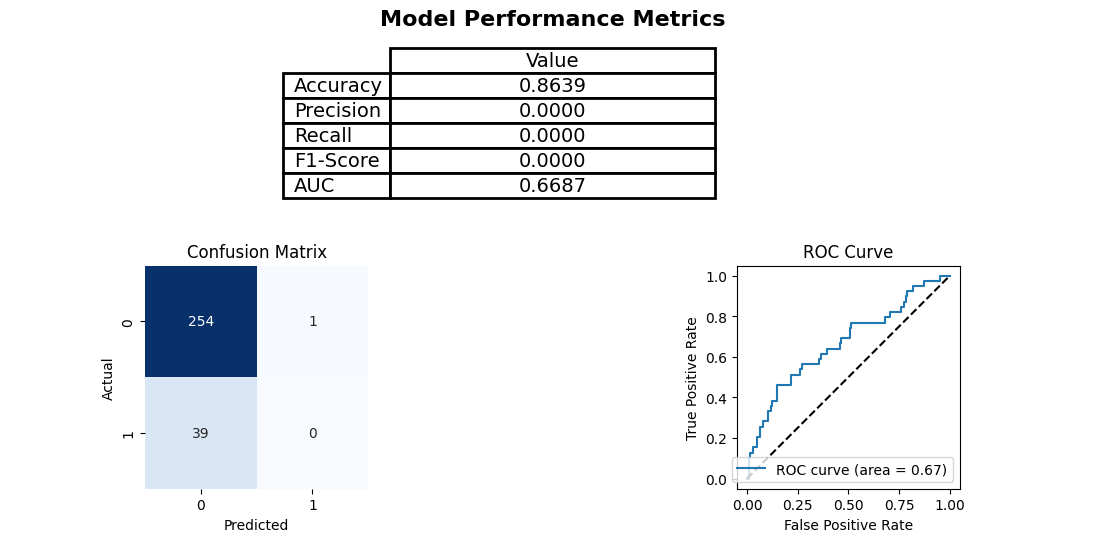

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Logistic Regression on Polynomial Features
model_poly = LogisticRegression()
model_poly.fit(X_poly, y_train)

# Predictions and Evaluation
X_test_poly = poly.transform(X_test)
y_pred_poly = model_poly.predict(X_test_poly)

summarise_model(model_poly, X_test_poly, y_test)

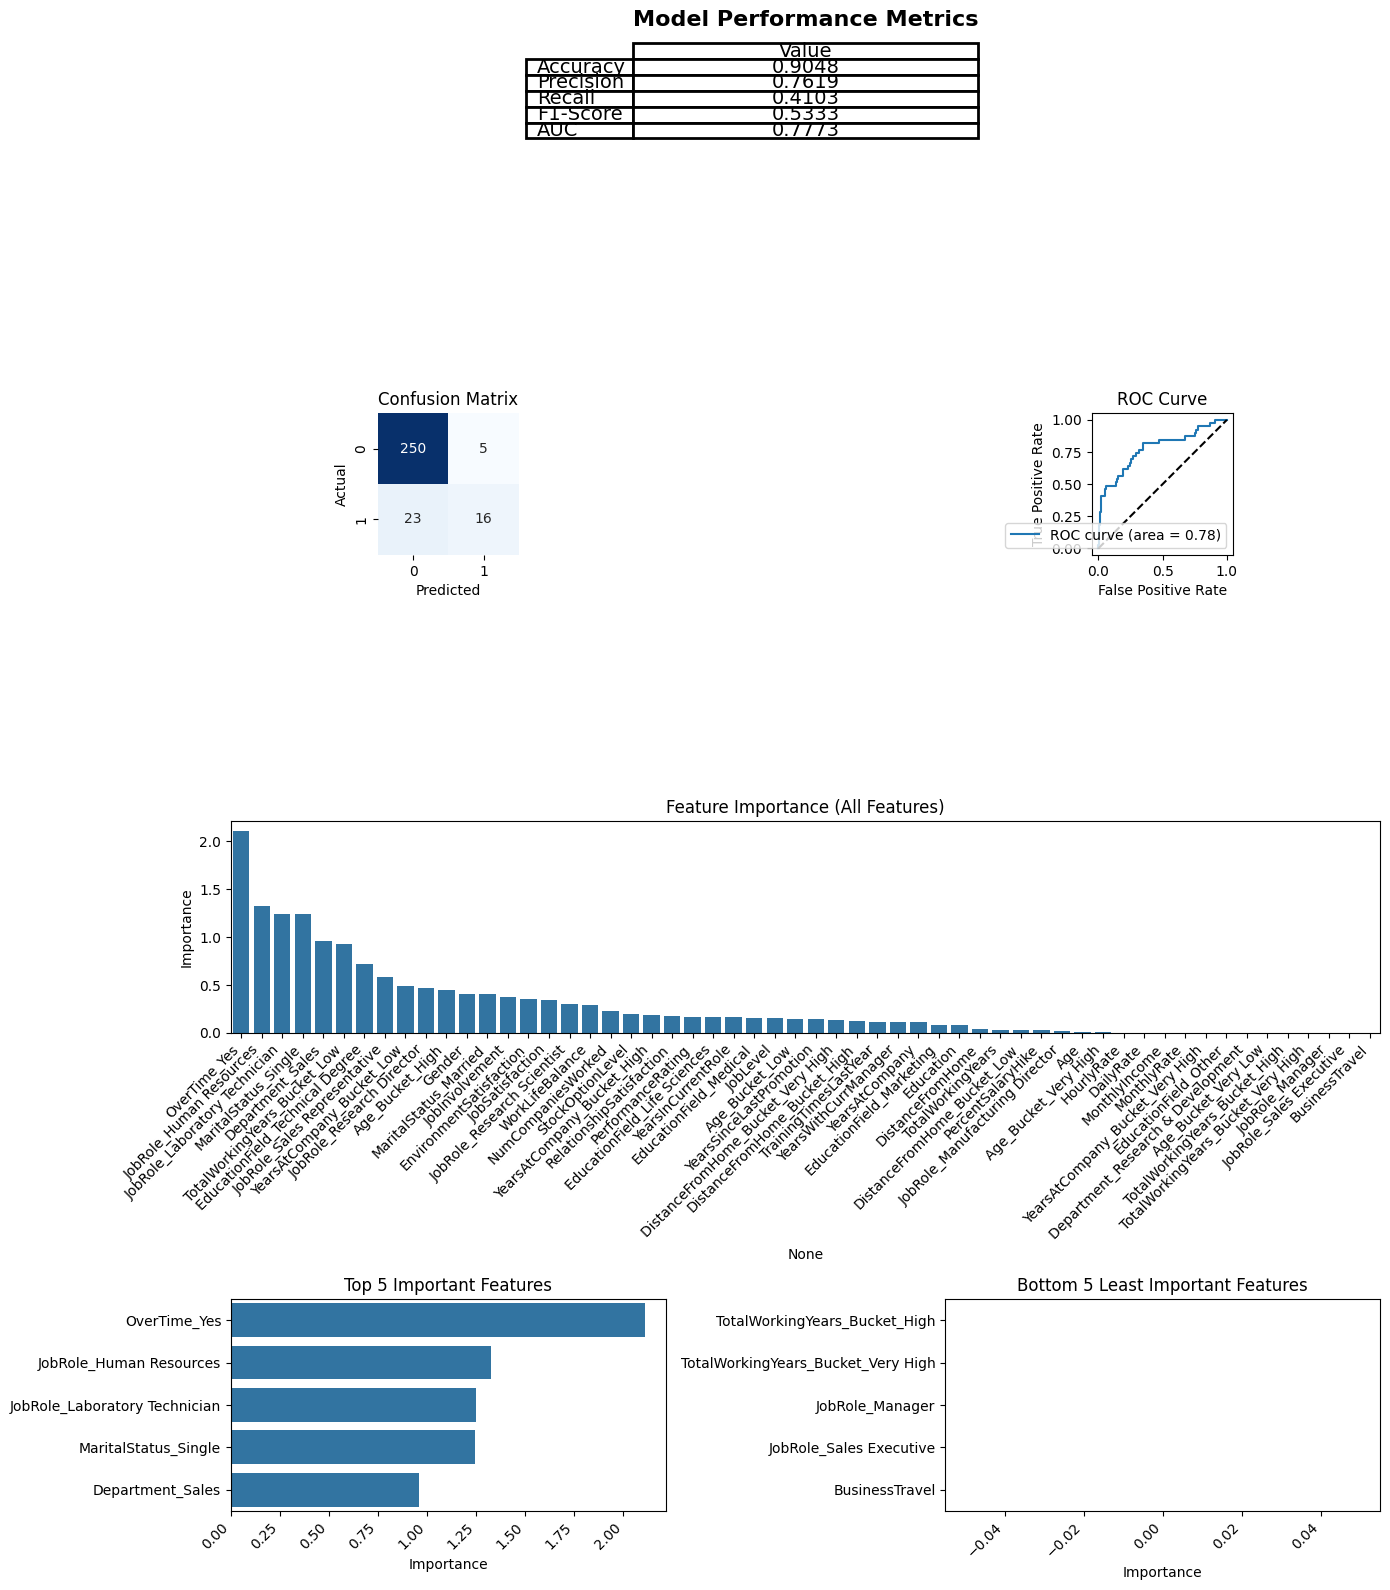

In [34]:
# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
model_l1.fit(X_train, y_train)
summarise_model(model_l1, X_test, y_test)




/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


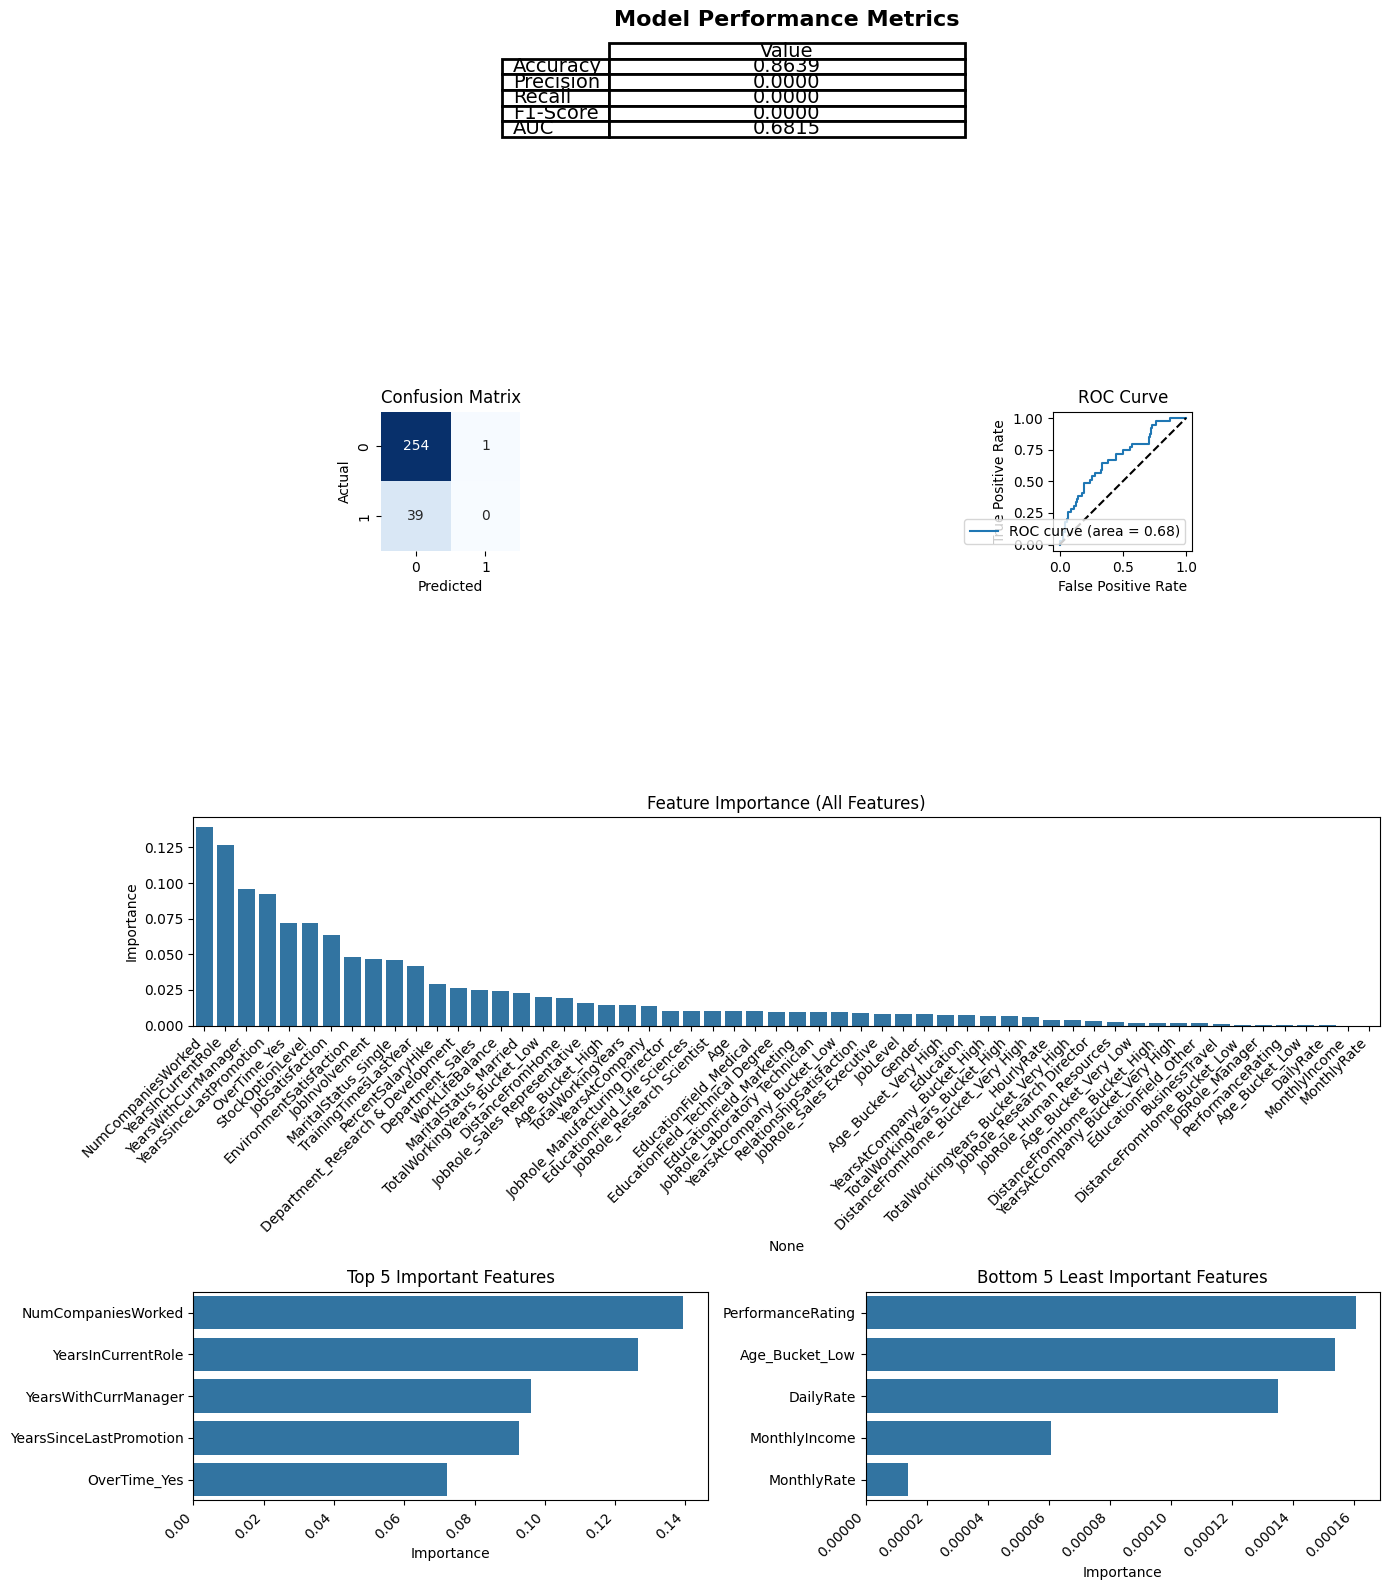

In [35]:

# L2 Regularization (default)
model_l2 = LogisticRegression(penalty='l2')
model_l2.fit(X_train, y_train)
summarise_model(model_l2, X_test, y_test)




/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


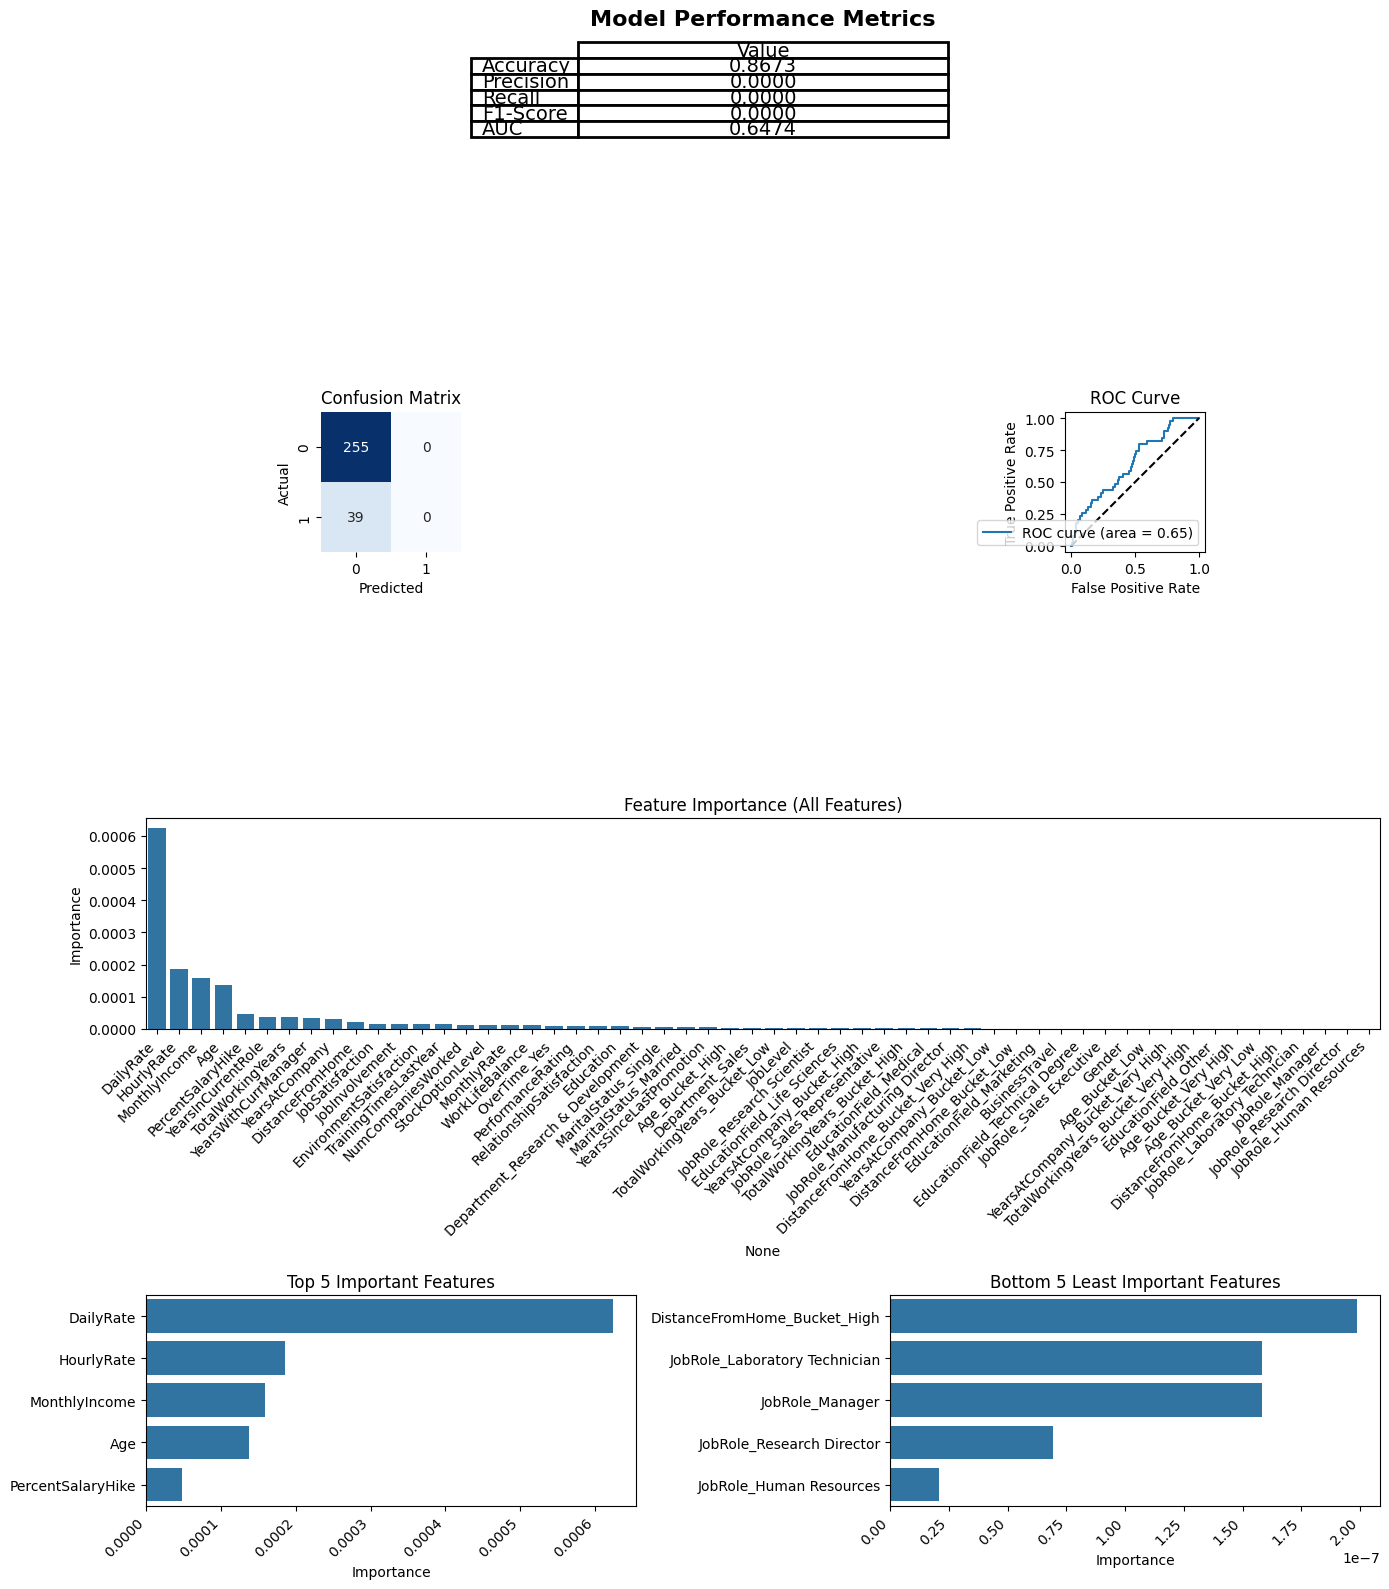

In [36]:

# ElasticNet Regularization
model_elastic = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
model_elastic.fit(X_train, y_train)
summarise_model(model_elastic, X_test, y_test)


In [81]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def evaluate_single_variable_models(data, target_column):
    # Ensure all columns are converted to numeric, coercing errors to NaN
    data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Drop rows with any NaN values after conversion
    data = data.dropna()

    # Check if all remaining columns are numeric
    if not all(data.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("Data contains non-numeric columns even after conversion.")

    # Store performance metrics
    performance_metrics = []

    # Iterate over each column in the data except the target
    for col in data.columns:
        if col == target_column:
            continue

        # Prepare the independent variable (X) and dependent variable (y)
        X = data[[col]]  # Single predictor
        y = data[target_column]

        # Add a constant to the model for the intercept
        X = sm.add_constant(X)

        # Fit the model
        try:
            model = sm.OLS(y, X).fit()
        except Exception as e:
            print(f"Failed to fit model with {col}: {e}")
            continue

        # Calculate performance metrics
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        mse = mean_squared_error(y, model.fittedvalues)

        # Append results to the list
        performance_metrics.append({
            'Variable': col,
            'R-squared': r_squared,
            'Adjusted R-squared': adj_r_squared,
            'MSE': mse
        })

    # Convert the results to a DataFrame for easy viewing
    performance_df = pd.DataFrame(performance_metrics)
    return performance_df

# Example usage
# Assuming 'data' is your DataFrame and 'price' is your target variable
# Replace 'price' with your actual target variable name
# performance_results = evaluate_single_variable_models(data, 'price')

# Display the performance results sorted by R-squared
# performance_results.sort_values(by='R-squared', ascending=False)


In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Model Accuracy: {grid_search.score(X_test, y_test):.4f}")


Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Model Accuracy: 0.8878


In [38]:
# Logistic Regression with Class Weight Adjustment
model_weighted = LogisticRegression(class_weight='balanced')
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)
print(f"Weighted Class Model Accuracy: {model_weighted.score(X_test, y_test):.4f}")


Weighted Class Model Accuracy: 0.6156


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
from sklearn.model_selection import cross_val_score

# Cross-validation with 5 folds
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Cross-validated Accuracy: {scores.mean():.4f}")


Cross-validated Accuracy: 0.8316


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [40]:
from sklearn.feature_selection import RFE

# Feature Selection with RFE
model_rfe = LogisticRegression()
rfe = RFE(model_rfe, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Fit and evaluate the model with selected features
y_pred_rfe = rfe.predict(X_test)
print(f"RFE Model Accuracy: {rfe.score(X_test, y_test):.4f}")


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

RFE Model Accuracy: 0.8741


In [ ]:
from sklearn.ensemble import BaggingClassifier

# Bagging with Logistic Regression
bagging_model = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=10)
bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)
print(f"Bagging Model Accuracy: {bagging_model.score(X_test, y_test):.4f}")


In [41]:
# Logistic Regression with default threshold
model_threshold = LogisticRegression()
model_threshold.fit(X_train, y_train)

# Predict probabilities
y_prob = model_threshold.predict_proba(X_test)[:, 1]

# Change the threshold to 0.4
y_pred_adjusted = (y_prob >= 0.4).astype(int)
print(f"Adjusted Threshold Model Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")


Adjusted Threshold Model Accuracy: 0.8537


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
from sklearn.metrics import classification_report, roc_auc_score

model_eval = LogisticRegression()
model_eval.fit(X_train, y_train)

y_pred_eval = model_eval.predict(X_test)
y_prob_eval = model_eval.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred_eval))

# AUC score
auc = roc_auc_score(y_test, y_prob_eval)
print(f"AUC Score: {auc:.4f}")


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.86       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.86      0.80       294

AUC Score: 0.6815


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Logistic Regression with PCA-transformed features
model_pca = LogisticRegression()
model_pca.fit(X_train_pca, y_train)

y_pred_pca = model_pca.predict(X_test_pca)
print(f"PCA Model Accuracy: {model_pca.score(X_test_pca, y_test):.4f}")


PCA Model Accuracy: 0.7891


/Users/Pato/Dev/Python/data_temps/ML_Templates/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
